# diagnosing $\alpha$ Cen

In [3]:
import jax

jax.config.update("jax_enable_x64", True)

import tinygp
from tinygp import GaussianProcess
from tinygp import kernels

#stock imports
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import pickle
import scipy
from scipy import constants
import os
from astropy.io import ascii
import astropy.constants
from cmcrameri import cm

##plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import corner

plt.style.use("Solarize_Light2")
plt.rcParams.update({"axes.edgecolor": "black"})
plt.rcParams.update({"text.color": "black"})
plt.rcParams.update({"axes.labelcolor": "black"})
plt.rcParams.update({"xtick.color": "black"})
plt.rcParams.update({"ytick.color": "black"})
plt.rcParams.update({"font.family": "monospace"})

#script imports
from scripts import prior_funcs, utils

from scripts.pitchfuncs_ultra_pca_v2 import emulator
from scripts.pitchfuncs_ultra_pca_v2 import ultra_ns_vector_surface
from scripts.pitchfuncs_ultra_pca_v2 import ultra_ns_popslice
from scripts.pitchfuncs_ultra_pca_v2 import ultra_ns_popwalk


import logging
logging.getLogger('ultranest').setLevel(logging.WARNING)

os.environ["CUDA_VISIBLE_DEVICES"]="0"

physical_devices = tf.config.list_physical_devices("GPU") 

#os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'


tf.config.experimental.set_memory_growth(physical_devices[0], True)

gpu0usage = tf.config.experimental.get_memory_info("GPU:0")["current"]

2025-01-23 05:03:53.527620: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-23 05:03:53.538560: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-23 05:03:53.541988: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-23 05:03:54.085518: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [30]:
df_full = pd.concat(
    [
        pd.read_hdf(
            "/home/oxs235/datastorage/repos_data/ojscutt/mesa_ajl/data/grid2p5a/grid.h5",
            key=f"m{0.8 + i*0.02:.2f}",
        )
        for i in range(21)
    ],
    ignore_index=True,
)
df = df_full[df_full["log_g"] >= 3.6]
df = df[df["star_age"] <= 14]
df = df[df["frac_age"] >= 0.015]

inputs = ["initial_mass", "initial_Zinit", "initial_Yinit", "initial_MLT", "star_age"]
outputs = (
    ["radius", "luminosity", "star_feh"]
    + [f"nu_0_{i}" for i in range(6, 41)]
    + ["nu_max"]
)

df = df.loc[(df[[f"nu_0_{i}" for i in range(6, 41)]] != 0).all(axis=1)]

cols = inputs + outputs

df = df[cols]

df.dropna(inplace=True)

df["calc_effective_T"] = utils.calc_Teff(df["luminosity"], df["radius"])
df.describe()

,initial_mass,initial_Zinit,initial_Yinit,initial_MLT,star_age,radius,luminosity,star_feh,nu_0_6,nu_0_7,...,nu_0_33,nu_0_34,nu_0_35,nu_0_36,nu_0_37,nu_0_38,nu_0_39,nu_0_40,nu_max,calc_effective_T
count,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,...,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06
mean,1.021885e+00,1.440698e-02,2.814693e-01,2.117984e+00,5.000177e+00,1.312728e+00,2.116482e+00,-1.127145e-01,7.726572e+02,8.860424e+02,...,3.696535e+03,3.802234e+03,3.907317e+03,4.011806e+03,4.115788e+03,4.219425e+03,4.322952e+03,4.426627e+03,2.370506e+03,5.866797e+03
std,1.175610e-01,9.677123e-03,2.805593e-02,2.879175e-01,3.405371e+00,4.813547e-01,1.572419e+00,3.499532e-01,2.959808e+02,3.426600e+02,...,1.451591e+03,1.494205e+03,1.536228e+03,1.577500e+03,1.617908e+03,1.657417e+03,1.696104e+03,1.734156e+03,1.156533e+03,5.670330e+02
min,8.000000e-01,3.869061e-03,2.400000e-01,1.700000e+00,2.966411e-02,6.990236e-01,1.321735e-01,-1.077903e+00,2.103102e+02,2.385545e+02,...,1.002125e+03,1.032723e+03,1.063221e+03,1.093511e+03,1.123625e+03,1.153506e+03,1.183191e+03,1.212653e+03,4.317504e+02,4.096930e+03
25%,9.200000e-01,6.471429e-03,2.600000e-01,1.900000e+00,2.309880e+00,9.719693e-01,9.371542e-01,-4.000000e-01,5.476978e+02,6.234189e+02,...,2.578850e+03,2.649156e+03,2.720741e+03,2.793748e+03,2.868279e+03,2.944027e+03,3.020312e+03,3.097018e+03,1.444480e+03,5.491841e+03
50%,1.040000e+00,1.077191e-02,2.800000e-01,2.100000e+00,4.275231e+00,1.160016e+00,1.698469e+00,-1.000000e-01,7.832912e+02,8.972267e+02,...,3.760636e+03,3.866328e+03,3.970106e+03,4.072429e+03,4.174203e+03,4.276548e+03,4.380549e+03,4.486487e+03,2.352665e+03,5.859776e+03
75%,1.120000e+00,2.007835e-02,3.000000e-01,2.300000e+00,7.159688e+00,1.498369e+00,2.883064e+00,1.837200e-01,9.935144e+02,1.142381e+03,...,4.784137e+03,4.922458e+03,5.059497e+03,5.194580e+03,5.327444e+03,5.458355e+03,5.587658e+03,5.716681e+03,3.185873e+03,6.219454e+03
max,1.200000e+00,3.897971e-02,3.200000e-01,2.500000e+00,1.399997e+01,2.873431e+00,1.163902e+01,5.094573e-01,1.480807e+03,1.705344e+03,...,7.145063e+03,7.354126e+03,7.562945e+03,7.771521e+03,7.979340e+03,8.185512e+03,8.382538e+03,8.584072e+03,5.856447e+03,7.993034e+03


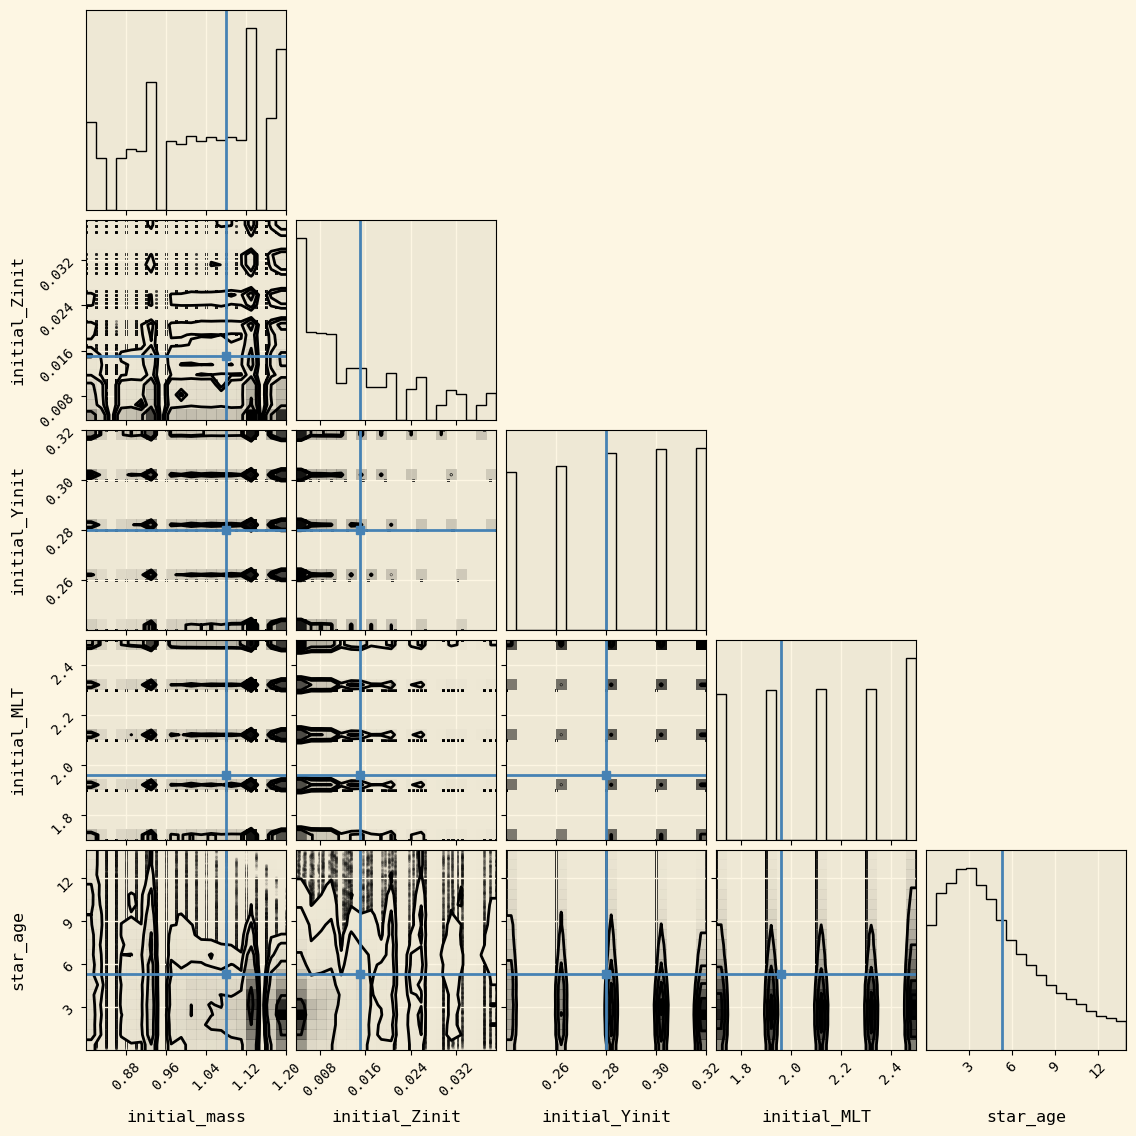

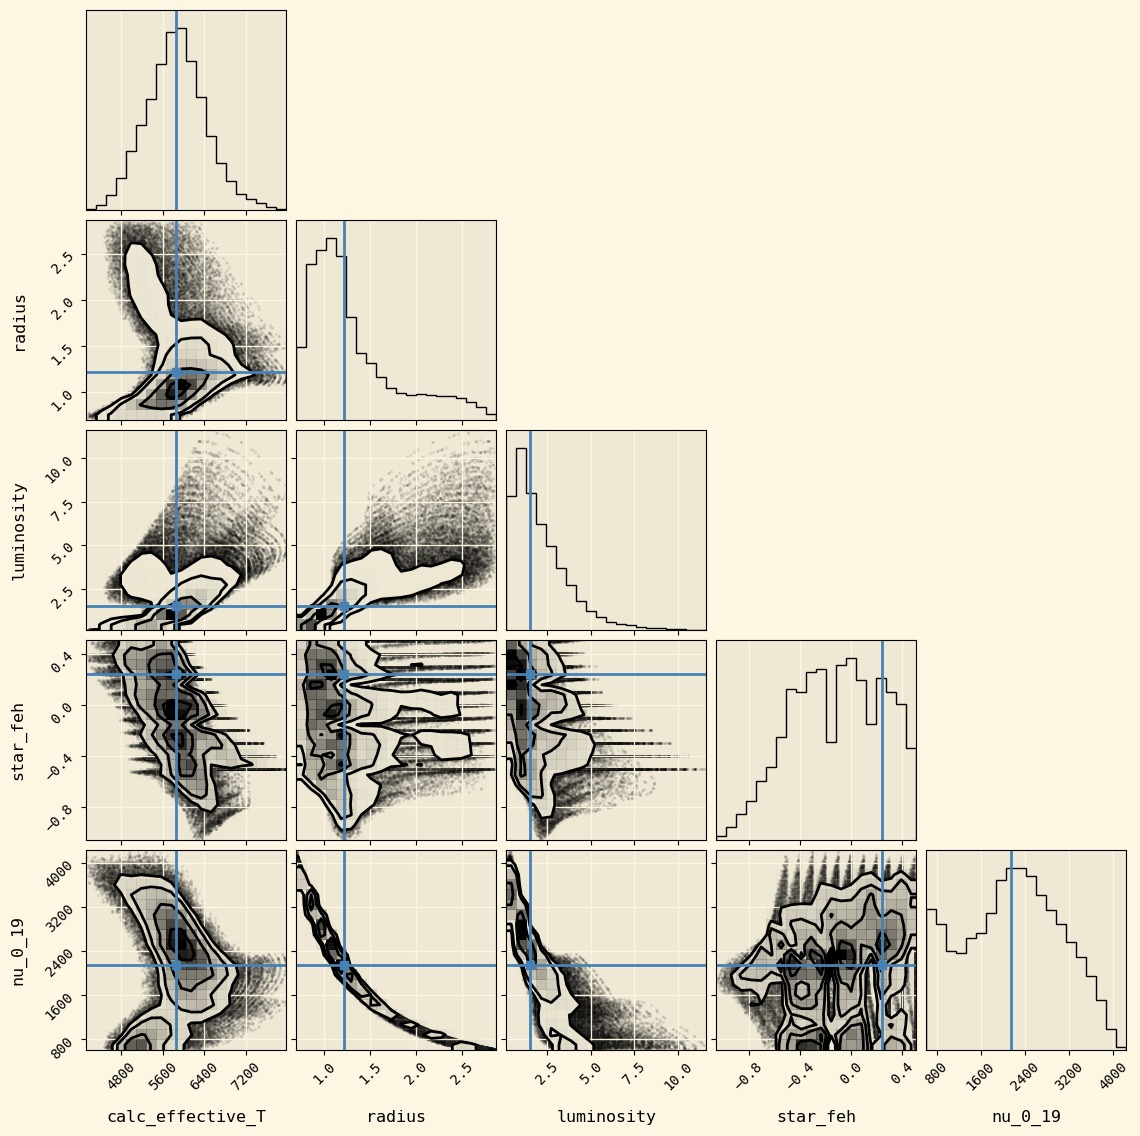

In [31]:
star_name = 'ACenA'
# HD128620

star_dict={}

star_dict['initial_mass']=[1.0788, 0.0029] #1
star_dict['initial_Zinit']= [0.015,0.03] #[0.034,0.03] #3, dubious
star_dict['initial_Yinit']= [0.28,0] #dubious
star_dict['initial_MLT']= [1.96, 0] #3
star_dict['star_age']=[5.3, 0.3] #3 

star_dict['nu_0_16']= [1841.3, 0.6]
star_dict['nu_0_17']= [1942.4, 0.6]
star_dict['nu_0_18']= [2046.4, 0.6]
star_dict['nu_0_19']= [2153.0, 0.4]
star_dict['nu_0_20']= [2258.7, 0.4]
star_dict['nu_0_21']= [2364.4, 0.5]
star_dict['nu_0_22']= [2469.9, 0.5]
star_dict['nu_0_23']= [2575.2, 0.6]
star_dict['nu_0_24']= [2682.1, 0.5]
star_dict['nu_0_25']= [2682.1 + 105.9, 1000]#
star_dict['nu_0_26']= [2895.4, 0.5]


star_dict['calc_effective_T']=[5847, 27] # mello 
star_dict['radius']= [1.2175, 0.0055] #1
star_dict['luminosity']= [1.5059, 0.0019] #1
star_dict['star_feh']=[0.24, 0.03] #2

star_dict['dnu'] =[105.9,0]
star_dict['nu_max'] = [2153.0, 0]

star_df = pd.DataFrame.from_dict(star_dict)

inputs = ["initial_mass", "initial_Zinit", "initial_Yinit", "initial_MLT", "star_age"]

truths = list(star_df[inputs].iloc[0].values)
df_sample = df.sample(100000)
corner.corner(df_sample[inputs].values, truths=truths, labels = inputs);

outputs = ['calc_effective_T', 'radius', 'luminosity', 'star_feh', 'nu_0_19']

truths = list(star_df[outputs].iloc[0].values)
corner.corner(df_sample[outputs].values, truths=truths, labels = outputs);

In [19]:
from scipy.spatial.distance import cdist
import os


def closest_grid_point(
    point,
    grid_df,
    a,
    b,
    columns=[
        "initial_mass",
        "initial_Zinit",
        "initial_Yinit",
        "initial_MLT",
        "star_age",
    ],
):

    closest_point = grid_df.iloc[[cdist([point], grid_df[columns].values).argmin()]].copy()

    closest_point['a'] = a
    closest_point['b'] = b
    
    return closest_point


In [20]:
input_labels = ["initial_mass", "initial_Zinit", "initial_Yinit", "initial_MLT"]

closest_point = closest_grid_point(list(star_df[input_labels].iloc[0].values), df[input_labels], columns = input_labels, a=1,b=1)

print(closest_point)

for input_label in input_labels:
    closest_point_val = closest_point[input_label].values[0]
    df = df[df[input_label] == closest_point_val]

         initial_mass  initial_Zinit  initial_Yinit  initial_MLT  a  b
5716139          1.08       0.016038           0.28          1.9  1  1


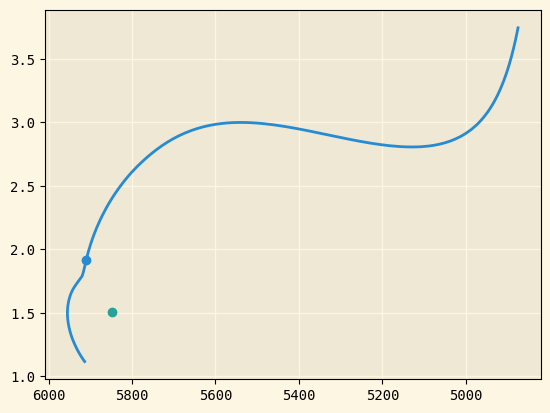

In [21]:
fig, ax = plt.subplots()
ax.plot(df["calc_effective_T"], df["luminosity"])

closest_age = df.iloc[(df['star_age']-5.3).abs().argsort()[:1]]
ax.scatter(closest_age["calc_effective_T"], closest_age["luminosity"])
ax.scatter(5847, 1.5059)
ax.invert_xaxis()


In [32]:
diffs = (df['luminosity'] - star_dict['luminosity'][0])**2 + (df['calc_effective_T'] - star_dict['calc_effective_T'][0])**2 + (df['star_feh'] - star_dict['star_feh'][0])**2

In [33]:
diffs.sort_values()

4073153    3.271395e-03
6154377    4.404618e-03
7627927    5.282650e-03
7762899    5.420229e-03
7762900    6.420356e-03
               ...     
8074268    4.594039e+06
8074270    4.595793e+06
8110115    4.600778e+06
7897351    4.600890e+06
8110114    4.605508e+06
Length: 2448681, dtype: float64

In [34]:
best_model = df.loc[diffs.sort_values().index[0]]

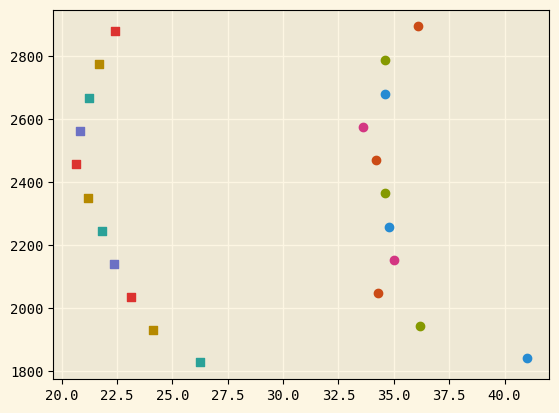

In [35]:
fig, ax = plt.subplots()

for n in range(16,27):
    ax.scatter(star_dict[f'nu_0_{n}'][0]%star_dict['dnu'][0], star_dict[f'nu_0_{n}'][0])
    ax.scatter(best_model[f'nu_0_{n}']%star_dict['dnu'][0], best_model[f'nu_0_{n}'], marker='s')


In [75]:
pitchfork_name = "nu6-40_elu_nonorm_feh"
pitchfork = emulator(pitchfork_name)

with open("pitchfork/" +pitchfork_name+ ".pkl", 'rb') as fp:
     pitchfork_info = pickle.load(fp)

pitchfork_ranges = pitchfork_info['parameter_ranges']

initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]


In [37]:
pitchfork.predict([best_model[["initial_mass", "initial_Zinit", "initial_Yinit", "initial_MLT", "star_age"]].values])

array([[5.85703258e+03, 1.49823648e+00, 2.27098398e-01, 7.61431869e+02,
        8.72821047e+02, 9.84453394e+02, 1.09419501e+03, 1.20088825e+03,
        1.30560955e+03, 1.41020737e+03, 1.51523785e+03, 1.61995086e+03,
        1.72384218e+03, 1.82726917e+03, 1.93102204e+03, 2.03555079e+03,
        2.14068981e+03, 2.24608183e+03, 2.35156777e+03, 2.45713931e+03,
        2.56297570e+03, 2.66904346e+03, 2.77517688e+03, 2.88158757e+03,
        2.98860483e+03, 3.09578021e+03, 3.20216235e+03, 3.30738858e+03,
        3.41186206e+03, 3.51594577e+03, 3.61915007e+03, 3.72030830e+03,
        3.81866126e+03, 3.91483578e+03, 4.01071354e+03, 4.10823356e+03,
        4.20830741e+03, 4.31078684e+03]])

In [38]:
outputs = (
    ['calc_effective_T', "luminosity", "star_feh"]
    + [f"nu_0_{i}" for i in range(6, 41)]
)


best_model[outputs].values - pitchfork.predict([best_model[["initial_mass", "initial_Zinit", "initial_Yinit", "initial_MLT", "star_age"]].values])

array([[-9.98018388e+00, -1.15800455e-02,  4.42277250e-04,
        -2.58958989e-01, -5.95076248e-03, -7.22341513e-01,
        -2.15802781e-01,  4.91833480e-03, -3.49349917e-01,
        -4.91582561e-01, -5.32238265e-01, -2.81931061e-01,
        -2.54998046e-01, -7.37796635e-01, -6.85238376e-01,
        -3.15215993e-01, -3.21137445e-01, -3.86333718e-01,
        -5.89164020e-01, -8.06561968e-01, -5.47276253e-01,
        -3.35288716e-01, -1.05001919e-01,  1.25049021e-01,
        -2.92426650e-01, -9.58400333e-01, -6.62080838e-01,
         2.60905147e-01,  1.06512643e+00, -4.97832209e-01,
        -2.44874296e-01,  2.30169743e-01,  7.67440631e-01,
         6.82100899e-01,  1.03760846e-01, -1.41949951e-02,
         4.14055081e-02,  3.62946736e-01]])

In [39]:
np.mean(best_model[outputs].values[3:-1] - best_model[outputs].values[4:])

-104.41108473589617

In [40]:
best_model

initial_mass           1.000000
initial_Zinit          0.023699
initial_Yinit          0.320000
initial_MLT            2.300000
star_age               7.286363
radius                 1.188186
luminosity             1.486656
star_feh               0.227541
nu_0_6               761.172910
nu_0_7               872.815096
nu_0_8               983.731053
nu_0_9              1093.979211
nu_0_10             1200.893167
nu_0_11             1305.260201
nu_0_12             1409.715789
nu_0_13             1514.705609
nu_0_14             1619.668933
nu_0_15             1723.587178
nu_0_16             1826.531377
nu_0_17             1930.336803
nu_0_18             2035.235569
nu_0_19             2140.368674
nu_0_20             2245.695495
nu_0_21             2350.978606
nu_0_22             2456.332751
nu_0_23             2562.428425
nu_0_24             2668.708172
nu_0_25             2775.071881
nu_0_26             2881.712622
nu_0_27             2988.312402
nu_0_28             3094.821810
nu_0_29 

In [41]:
pitchfork.predict([best_model[["initial_mass", "initial_Zinit", "initial_Yinit", "initial_MLT", "star_age"]].values])

array([[5.85703258e+03, 1.49823648e+00, 2.27098398e-01, 7.61431869e+02,
        8.72821047e+02, 9.84453394e+02, 1.09419501e+03, 1.20088825e+03,
        1.30560955e+03, 1.41020737e+03, 1.51523785e+03, 1.61995086e+03,
        1.72384218e+03, 1.82726917e+03, 1.93102204e+03, 2.03555079e+03,
        2.14068981e+03, 2.24608183e+03, 2.35156777e+03, 2.45713931e+03,
        2.56297570e+03, 2.66904346e+03, 2.77517688e+03, 2.88158757e+03,
        2.98860483e+03, 3.09578021e+03, 3.20216235e+03, 3.30738858e+03,
        3.41186206e+03, 3.51594577e+03, 3.61915007e+03, 3.72030830e+03,
        3.81866126e+03, 3.91483578e+03, 4.01071354e+03, 4.10823356e+03,
        4.20830741e+03, 4.31078684e+03]])

## prior predictive

In [50]:
pitchfork_name = "nu6-40_elu_nonorm_feh"
pitchfork = emulator(pitchfork_name)

with open("pitchfork/" +pitchfork_name+ ".pkl", 'rb') as fp:
     pitchfork_info = pickle.load(fp)

pitchfork_ranges = pitchfork_info['parameter_ranges']

initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]


In [97]:
labels = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age', 'a', 'b']

mass_prior = prior_funcs.custom_beta_prior(0.8, 1.2, a=5, b=2)

Zinit_prior = prior_funcs.custom_beta_prior(0.004, 0.038, a=2, b=5)

Yinit_prior = prior_funcs.custom_beta_prior(0.24, 0.32, a=2, b=5)

MLT_prior = prior_funcs.custom_beta_prior(1.7, 2.5, a=1.2, b=1.2)

age_prior = prior_funcs.custom_beta_prior(0.03, 14, a=1.2, b=1.2)

priors = [mass_prior, Zinit_prior, Yinit_prior, MLT_prior, age_prior]

size = 100000
prior_samples = np.array([prior.rvs(size=size) for prior in priors])

outputs = outputs = (
    ["calc_effective_T", "luminosity", "star_feh"]
    + [f"nu_0_{i}" for i in range(6, 41)]
)
preds = pd.DataFrame(np.concatenate((prior_samples,pitchfork.predict(prior_samples.T).T)).T, columns=inputs+outputs)

In [110]:
pitchfork_blunders[inputs].values[0]

array([1.09134115e+00, 5.78142482e-03, 2.74169137e-01, 2.02193453e+00,
       1.22173697e+01])

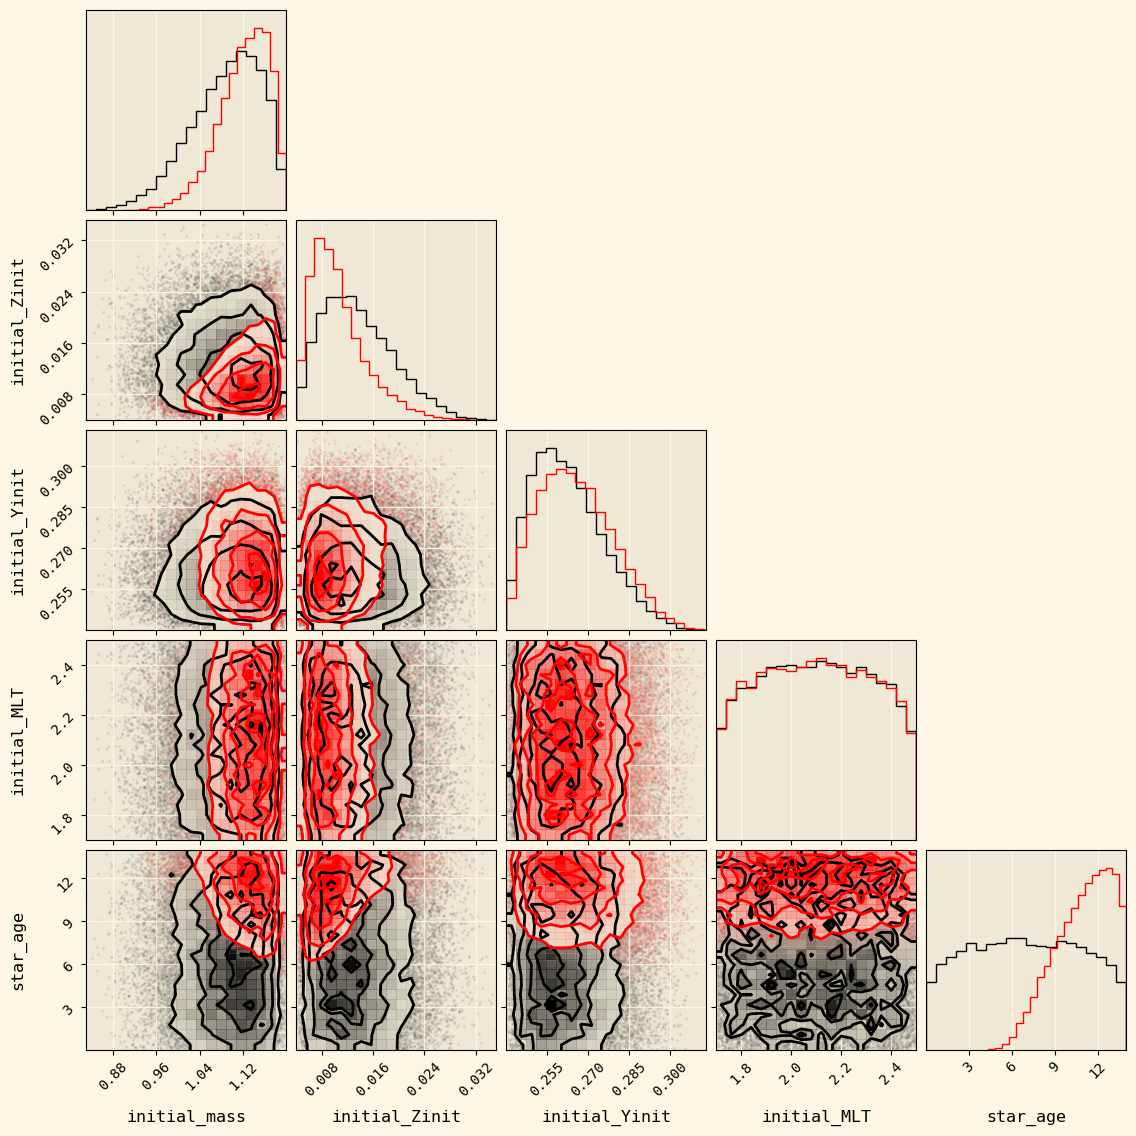

In [111]:
pitchfork_blunders = preds[preds['luminosity']>1000]


reduced_prior_samples = np.array([prior.rvs(size=len(pitchfork_blunders)) for prior in priors])


fig = corner.corner(reduced_prior_samples.T)
corner.corner(pitchfork_blunders[inputs].values, fig=fig, color='red', labels=inputs);

In [112]:
df_full = pd.concat(
    [
        pd.read_hdf(
            "/home/oxs235/datastorage/repos_data/ojscutt/mesa_ajl/data/grid2p5a/grid.h5",
            key=f"m{0.8 + i*0.02:.2f}",
        )
        for i in range(21)
    ],
    ignore_index=True,
)
df = df_full[df_full["log_g"] >= 3.6]
df = df[df["star_age"] <= 14]
df = df[df["frac_age"] >= 0.015]

inputs = ["initial_mass", "initial_Zinit", "initial_Yinit", "initial_MLT", "star_age"]
outputs = (
    ["radius", "luminosity", "star_feh"]
    + [f"nu_0_{i}" for i in range(6, 41)]
    + ["nu_max"]
)

df = df.loc[(df[[f"nu_0_{i}" for i in range(6, 41)]] != 0).all(axis=1)]

cols = inputs + outputs

df = df[cols]

df.dropna(inplace=True)

df["calc_effective_T"] = utils.calc_Teff(df["luminosity"], df["radius"])
df.describe()

,initial_mass,initial_Zinit,initial_Yinit,initial_MLT,star_age,radius,luminosity,star_feh,nu_0_6,nu_0_7,...,nu_0_33,nu_0_34,nu_0_35,nu_0_36,nu_0_37,nu_0_38,nu_0_39,nu_0_40,nu_max,calc_effective_T
count,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,...,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06,2.448681e+06
mean,1.021885e+00,1.440698e-02,2.814693e-01,2.117984e+00,5.000177e+00,1.312728e+00,2.116482e+00,-1.127145e-01,7.726572e+02,8.860424e+02,...,3.696535e+03,3.802234e+03,3.907317e+03,4.011806e+03,4.115788e+03,4.219425e+03,4.322952e+03,4.426627e+03,2.370506e+03,5.866797e+03
std,1.175610e-01,9.677123e-03,2.805593e-02,2.879175e-01,3.405371e+00,4.813547e-01,1.572419e+00,3.499532e-01,2.959808e+02,3.426600e+02,...,1.451591e+03,1.494205e+03,1.536228e+03,1.577500e+03,1.617908e+03,1.657417e+03,1.696104e+03,1.734156e+03,1.156533e+03,5.670330e+02
min,8.000000e-01,3.869061e-03,2.400000e-01,1.700000e+00,2.966411e-02,6.990236e-01,1.321735e-01,-1.077903e+00,2.103102e+02,2.385545e+02,...,1.002125e+03,1.032723e+03,1.063221e+03,1.093511e+03,1.123625e+03,1.153506e+03,1.183191e+03,1.212653e+03,4.317504e+02,4.096930e+03
25%,9.200000e-01,6.471429e-03,2.600000e-01,1.900000e+00,2.309880e+00,9.719693e-01,9.371542e-01,-4.000000e-01,5.476978e+02,6.234189e+02,...,2.578850e+03,2.649156e+03,2.720741e+03,2.793748e+03,2.868279e+03,2.944027e+03,3.020312e+03,3.097018e+03,1.444480e+03,5.491841e+03
50%,1.040000e+00,1.077191e-02,2.800000e-01,2.100000e+00,4.275231e+00,1.160016e+00,1.698469e+00,-1.000000e-01,7.832912e+02,8.972267e+02,...,3.760636e+03,3.866328e+03,3.970106e+03,4.072429e+03,4.174203e+03,4.276548e+03,4.380549e+03,4.486487e+03,2.352665e+03,5.859776e+03
75%,1.120000e+00,2.007835e-02,3.000000e-01,2.300000e+00,7.159688e+00,1.498369e+00,2.883064e+00,1.837200e-01,9.935144e+02,1.142381e+03,...,4.784137e+03,4.922458e+03,5.059497e+03,5.194580e+03,5.327444e+03,5.458355e+03,5.587658e+03,5.716681e+03,3.185873e+03,6.219454e+03
max,1.200000e+00,3.897971e-02,3.200000e-01,2.500000e+00,1.399997e+01,2.873431e+00,1.163902e+01,5.094573e-01,1.480807e+03,1.705344e+03,...,7.145063e+03,7.354126e+03,7.562945e+03,7.771521e+03,7.979340e+03,8.185512e+03,8.382538e+03,8.584072e+03,5.856447e+03,7.993034e+03


In [113]:
df_preds = pitchfork.predict(df[inputs])

In [114]:
df_preds[:,1].max()

11.752058608104463

In [115]:
downsampled_df = df[['initial_mass','initial_Zinit', 'star_age']].sample(len(pitchfork_blunders))
downsampled_df

,initial_mass,initial_Zinit,star_age
2239795,0.90,0.007677,3.070337
3655664,0.98,0.019516,1.747548
3377256,0.96,0.026487,5.825136
1863659,0.88,0.006112,4.135842
7143677,1.16,0.013156,2.154257
...,...,...,...
4667780,1.04,0.016928,6.013990
1472320,0.86,0.016927,7.687299
7717135,1.18,0.004325,4.346508
978953,0.84,0.005150,12.220292


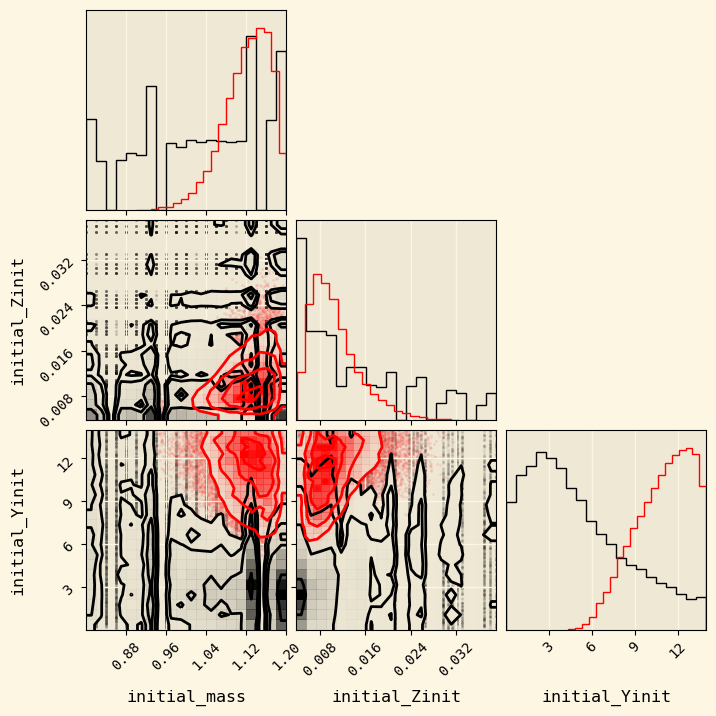

In [117]:
fig = corner.corner(downsampled_df[['initial_mass','initial_Zinit', 'star_age']].values, labels=inputs)
corner.corner(pitchfork_blunders[['initial_mass','initial_Zinit', 'star_age']].values, color='red', fig=fig);

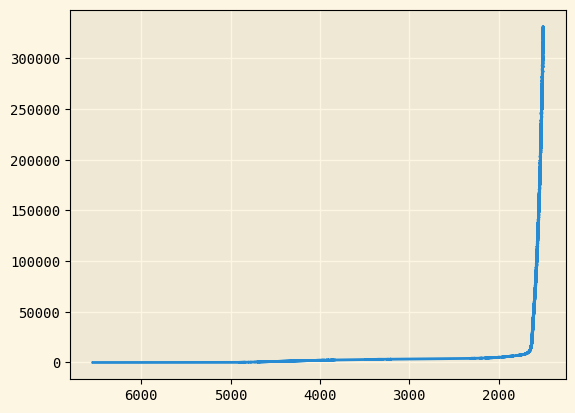

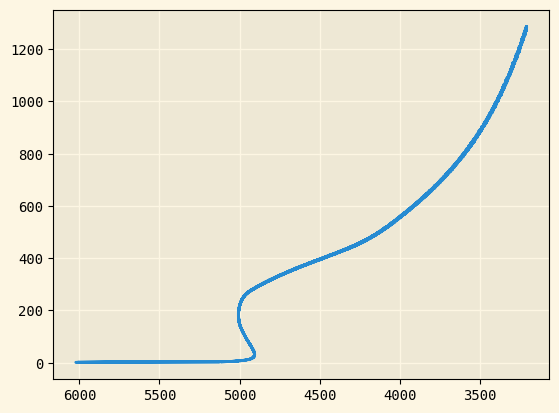

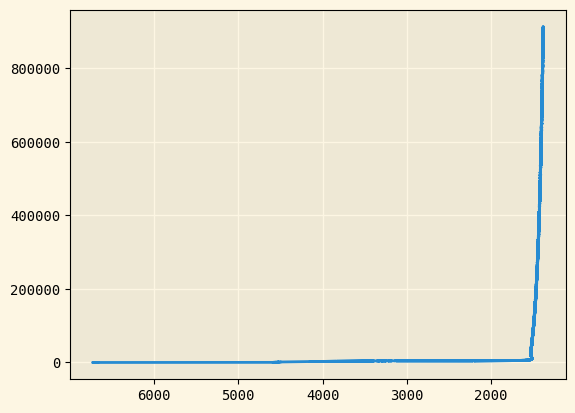

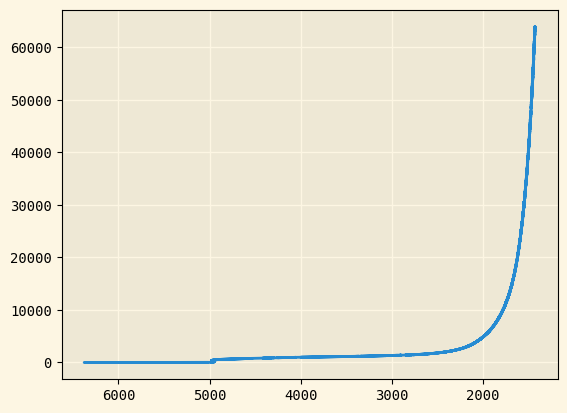

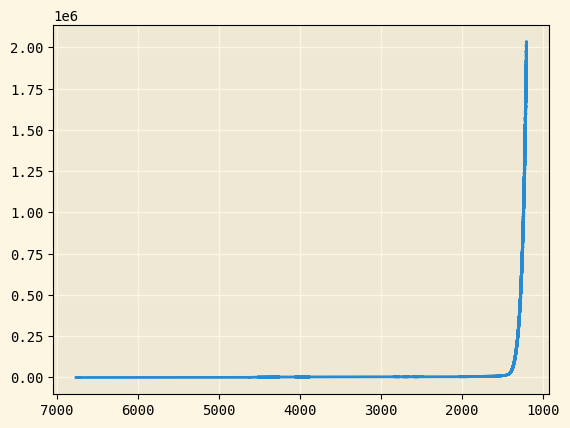

In [159]:
inputs = ["initial_mass", "initial_Zinit", "initial_Yinit", "initial_MLT"]
for plot_index in range(5):
    sample_blunder = pitchfork_blunders[inputs].iloc[plot_index].values
    
    timesteps = np.linspace(0.1,14,int(1e6))
    
    blunder_df = pd.DataFrame(timesteps, columns=['star_age'])
    
    i=0
    for single_input in inputs:
        blunder_df[single_input] = sample_blunder[i]
        i+=1
    
    blunder_df=blunder_df[inputs+['star_age']]
    
    outputs = (
        ["calc_effective_T", "luminosity", "star_feh"]
        + [f"nu_0_{i}" for i in range(6, 41)]
    )
    
    blunder_preds = pd.DataFrame(pitchfork.predict(blunder_df), columns=outputs)
    
    fig, ax = plt.subplots()
    ax.plot(blunder_preds['calc_effective_T'], blunder_preds['luminosity'])
    ax.invert_xaxis()
    plt.show()